In [256]:
import torch
from sbi import utils as utils
from sbi import analysis as analysis
from sbi.inference.base import infer
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from scipy.linalg import inv
from numpy.random import multivariate_normal
from notebook.services.config import ConfigManager
from traitlets.config.manager import BaseJSONConfigManager
import matplotlib as mpl
import math



# set jupyter configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*1.2

# the commented out configuration code below enables scrolling in slide mode
# TODO figure out a clean way to do this
# path = "/home/stefan/.jupyter/nbconfig" # update with your path
# cm = BaseJSONConfigManager(config_dir=path)
# cm.update('livereveal', {
#               'theme': 'white',
#               'transition': 'fade',
#               'start_slideshow_at': 'selected',
#                 'center' : False,
#                 'width' : 1024,
#                 'height': 768,   
#                 'scroll': True,
#                 'slideNumber': True,
# })

# set global variables
gt_color = 'r'
data_color = '#0000FF'
linreg_color = '#519872'
abc_color = 'purple'
sbi_color  = '#DE1A1A'

domain = np.linspace(0,1,11)
SIGMA = 0.3

In [298]:
def ballistic(launch_velocity, launch_angle, drag_coefficient=1.0000e-6, sample=False):
    """ ... """
    y_t = lambda t: launch_velocity * t * np.sin(math.radians(launch_angle)) - 0.5*9.81*t**2 
    x = np.linspace(0,100,101)
    y = y_t(x)

    samples = y + np.random.randn(x.shape[0]) * 150
   
    plt.plot(x,y, label='Ground truth', color=gt_color)
    if sample:
        plt.scatter(x, samples,label='Samples', marker='x', color=data_color)
    plt.ylim(0)
    plt.xlim(0)
    plt.legend()
    plt.show()
    
    return {
        'param':[launch_velocity, launch_angle, drag_coefficient],
        'y': y,
        'samples':samples
    }

ground_truth = interactive(ballistic, launch_velocity=(50,500), launch_angle=(30,60), sample=False)
ground_truth 

interactive(children=(IntSlider(value=275, description='launch_velocity', max=500, min=50), IntSlider(value=45…

- Ground truth function with unknown parameters
- Sampling is only possible with measurement noise $\sigma^2$
- Let's try linear regression as baseline

In [391]:
# get data from ground truth
ground_truth_param = np.array(ground_truth.result['param'])
data = ground_truth.result['samples']

X = np.linspace(0,100,101)
# # linear regression baseline
features = np.array([X**0, X**1, X**2]).T
linreg_param = inv(features.T @ features).dot(features.T @ data)
linreg_reconstruction = features @ linreg_param
# and compute error
# precicion_matrix = np.array([[(features[:,i]*features[:,j]).sum()/SIGMA**2 for i in range(3)] for j in range(3)])
# linreg_covariance = inv(precicion_matrix)
# linreg_error = np.diag(linreg_covariance)**0.5

/home/stefan/anaconda3/envs/sbi_workshop/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  This is separate from the ipykernel package so we can avoid doing imports until


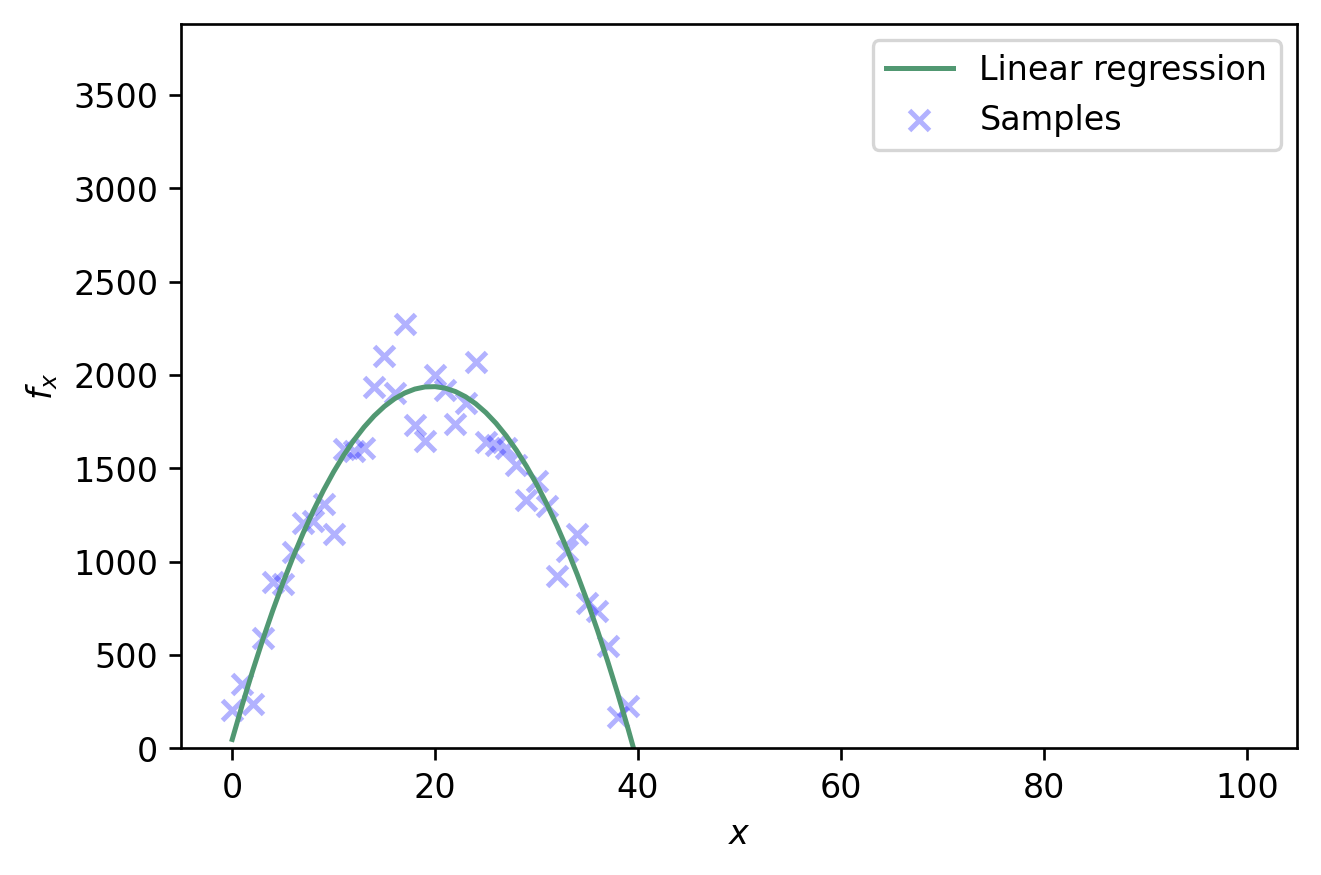

In [392]:
# plotting
plt.scatter(X, data, marker='x', label='Samples', color=data_color, alpha=0.3)
plt.plot(X, linreg_reconstruction, 'k', label = 'Linear regression', color=linreg_color)
# plt.plot(X,ground_truth.result['y'], 'r:',color=gt_color, alpha=0.8, label='Ground truth')

plt.legend()
plt.ylim(0)
plt.xlabel('$x$')
plt.ylabel('$f_x$')
plt.show()

- What if we didn't know about linear regression?
- We know underlying parameters but not their values

Text(0.5, 1.0, 'Error for $v_0=275.6$ and $\\theta=49.7$: 1820.65')

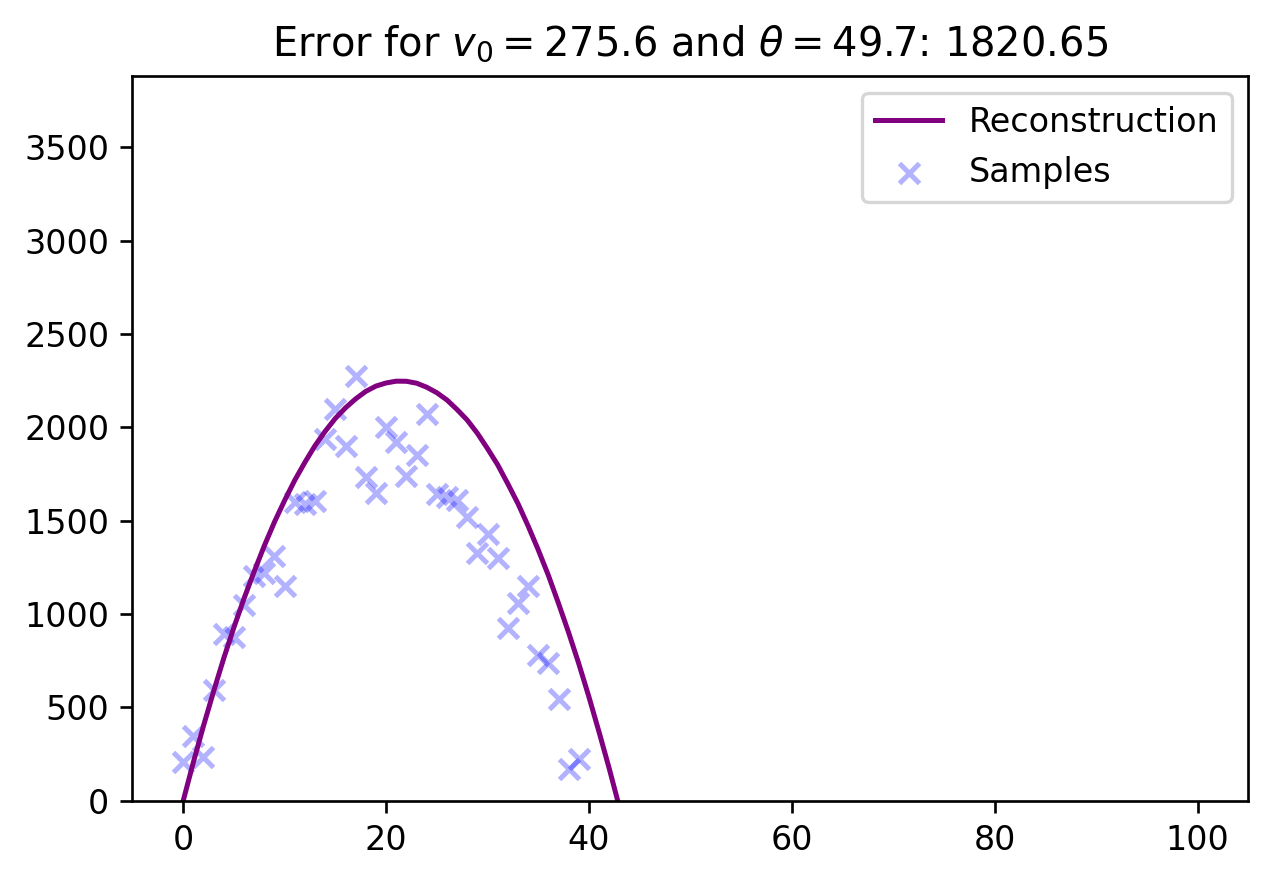

In [609]:
def ballistic_simulator(param, domain = X, noise_std=SIGMA):
    y_t = lambda t: param[0] * t * np.sin(math.radians(param[1])) - 0.5*9.81*t**2 
    return y_t(domain) + np.random.randn(domain.shape[0]) #* 250


def distance(distance_function, prediction, data):
    """ Second-order function that takes in a distance function and its arguments and returns the result. """
    return distance_function(prediction, data)



# sample parameters from a uniform distribution
param = np.array([np.random.uniform(200, 350), np.random.uniform(40, 50)])


# pass parameters to simulator and see result
prediction = ballistic_simulator(param, X)
plt.plot(prediction, label='Reconstruction', color=abc_color)
plt.scatter(X, data, marker='x', label='Samples', color=data_color, alpha=0.3)

plt.ylim(0)
plt.legend()




# write own distance functions
mse = lambda prediction, data: np.square(prediction - data).mean()
chebyshev = lambda prediction, data: max([np.abs(data[i]-prediction[i]) for i in range(data.shape[0])])

# what would be a good acceptance threshold?
plt.title(f'Error for $v_0={param[0]:.1f}$ and $\\theta={param[1]:.1f}$: {distance(chebyshev, prediction, data):.2f}')

In [618]:
num_simulations = 100
best_param = None
for _ in range(num_simulations):
    param = np.array([np.random.uniform(50, 500), np.random.uniform(30, 60)])
    # pass to simulator
    prediction = ballistic_simulator(param, X)
    # compute distance
    dist = distance(chebyshev, prediction, data)
    # check if within epsilon
    if dist < 500:
        # if so return parameters
        best_param = param
print(best_param)

[302.21543298  40.29819154]


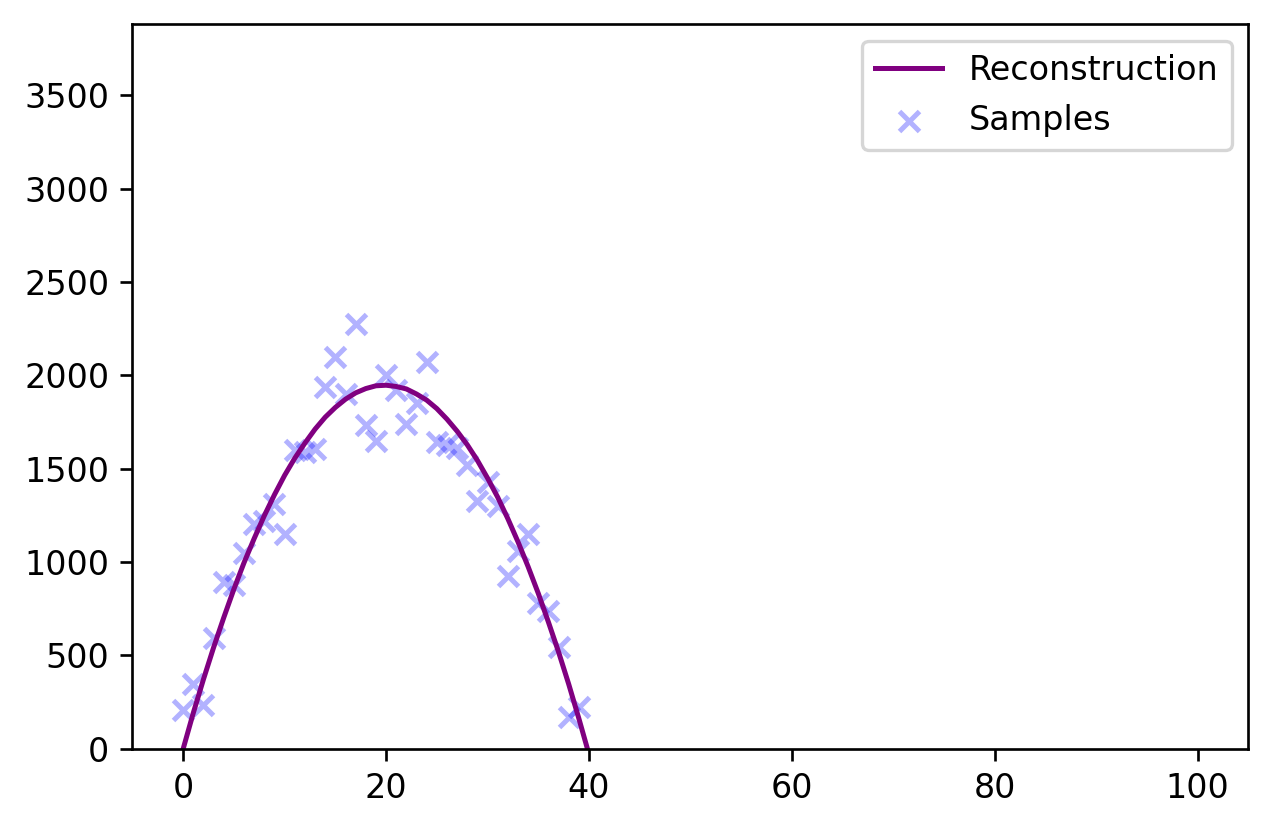

In [619]:
# plot with found parameters
plt.plot(ballistic_simulator(best_param, X), label='Reconstruction', color=abc_color)
plt.scatter(X, data, marker='x', label='Samples', color=data_color, alpha=0.3)

plt.ylim(0)
plt.legend()

- But this is a Simulation-based Inference workshop
- Couldn't we also build a simulator that models interesting polynomials like this? 

- How can we use this simulator? 
- Simply try out different parameter combinations until we find a one that produces a result similar to our data?
- Or, we could use the `sbi` toolbox.

In [ ]:
# perform simulation based inference using a uniform prior and our simulator as likelihood
prior = utils.BoxUniform(low=-2*torch.ones(3), high=2*torch.ones(3))
posterior = infer(quadratic_simulator, prior, method='SNPE', num_simulations=300)

In [ ]:
# sample from our posterior over parameters
sample = posterior.sample((10000,), x=data)
sbi_param = sample.mean(dim =0).numpy()
sbi_reconstruction = features @ sbi_param

# plotting
plt.plot(domain, sbi_reconstruction, 'k', label = 'SBI', color=sbi_color)
plt.plot(domain, linreg_reconstruction, label='Linear Regression', color=linreg_color)
plt.scatter(domain, data, marker='x', label='Samples', color=data_color)
plt.plot(domain,ground_truth.result['y'], 'r:',color=gt_color, alpha=0.3, label='Ground truth')
plt.legend()
plt.xlabel('$x$')
plt.ylabel('$f_x$')
plt.ylim(-1.2, 1.2)
plt.show()

Let's have a closer look at the parameters predicted by linear regression and SBI respectively.

In [ ]:
# linreg
linreg_samples = multivariate_normal(linreg_param, linreg_covariance, size=10000)
fig, axes = analysis.pairplot(linreg_samples,
                           points=ground_truth_param,
                           points_offdiag={'markersize': 12},
                           points_colors='r',
                           title='Linear Regression',
                           figsize=(6,6))


# sbi
_ = analysis.pairplot(sample,
                      points=ground_truth_param,
                      points_offdiag={'markersize': 12},
                      points_colors='r',
                      title='SBI',
                      figsize=(6,6))